<a href="https://colab.research.google.com/github/Eezzeldin/candy/blob/elasticity_first_then_binning/candy_priceElasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np

In [22]:
binary_features_cols = ["chocolate" ,
                   "fruity"    ,
                   "caramel"   ,
                   "peanutyalmondy",
                   'nougat'    ,
                   "crispedricewafer" ,
                   "hard"      ,
                   "bar"       ,
                   "pluribus"
                   ]
non_feature_cols   = ["competitorname" , "winpercent" , "pricepercent"]

In [23]:
data = pd.read_csv ("/content/candy-data.csv")
data

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,Welch's Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,Werther's Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define parameter space for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
}

 # Define independent variables (X) and dependent variable (y)
X       = data.drop(non_feature_cols, axis=1)
y_price = data['pricepercent']
y_win   = data['winpercent']

In [25]:
# Setup and fit RandomizedSearchCV for 'pricepercent'
rs_price = RandomizedSearchCV(RandomForestRegressor(), param_distributions, n_iter=50, cv=3, n_jobs = -1 ,verbose = 100 ,random_state=42)
rs_price.fit(X, y_price)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c7d67dde950>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c7d67dddea0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c7d67cc3670>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c7d67cc3d90>},
                   random_state=42, verbose=100)

In [26]:
# Setup and fit RandomizedSearchCV for 'winpercent'
rs_win = RandomizedSearchCV(RandomForestRegressor(), param_distributions, n_iter=50, cv=3, n_jobs = -1,verbose = 100 ,random_state=42)
rs_win.fit(X, y_win)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c7d67dde950>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c7d67dddea0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c7d67cc3670>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c7d67cc3d90>},
                   random_state=42, verbose=100)

In [27]:
y_price_pred = rs_price.predict (X)
y_win_pred   = rs_win.predict (X)

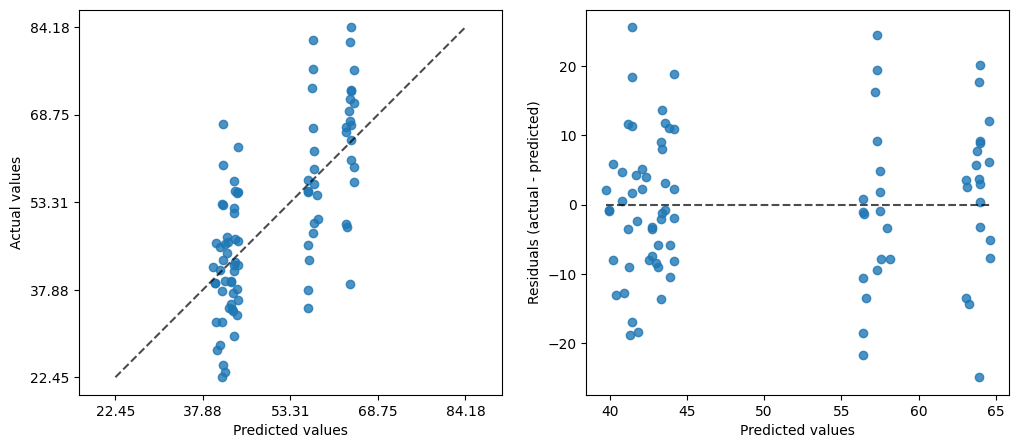

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_estimator(
    rs_win, X, y_win, kind="actual_vs_predicted", ax=axs[0]
)
_ = PredictionErrorDisplay.from_estimator(
    rs_win, X, y_win, kind="residual_vs_predicted", ax=axs[1]
)

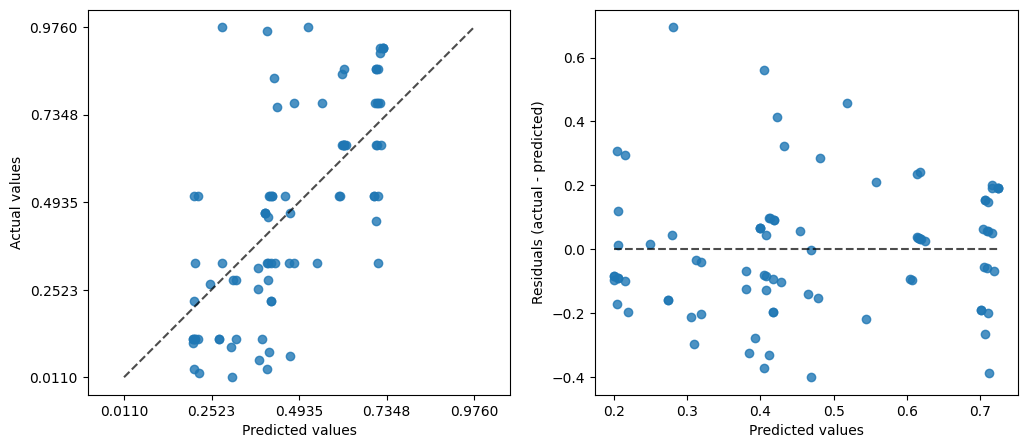

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_estimator(
    rs_price, X, y_price, kind="actual_vs_predicted", ax=axs[0]
)
_ = PredictionErrorDisplay.from_estimator(
    rs_price, X, y_price, kind="residual_vs_predicted", ax=axs[1]
)

In [7]:
from sklearn.preprocessing import KBinsDiscretizer

# Dropping the 'competitorname' column
data_prepared = data.drop(['competitorname'], axis=1)

# Binning 'sugarpercent' into quartiles
sugar_binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
data_prepared['sugar_bin'] = sugar_binner.fit_transform(data_prepared[['sugarpercent']])

# Display the first few rows of the modified dataframe and the bins
data_prepared.head(), sugar_binner.bin_edges_[0]


(   chocolate  fruity  caramel  peanutyalmondy  nougat  crispedricewafer  hard  \
 0          1       0        1               0       0                 1     0   
 1          1       0        0               0       1                 0     0   
 2          0       0        0               0       0                 0     0   
 3          0       0        0               0       0                 0     0   
 4          0       1        0               0       0                 0     0   
 
    bar  pluribus  sugarpercent  pricepercent  winpercent  sugar_bin  
 0    1         0         0.732         0.860   66.971725        3.0  
 1    1         0         0.604         0.511   67.602936        2.0  
 2    0         0         0.011         0.116   32.261086        0.0  
 3    0         0         0.011         0.511   46.116505        0.0  
 4    0         0         0.906         0.511   52.341465        3.0  ,
 array([0.011     , 0.22      , 0.465     , 0.73199999, 0.98799998]))

In [8]:
# Calculate the size (number of candies) per sugar bin
bin_sizes = data_prepared.groupby('sugar_bin').size()

# Convert the bin_sizes to a DataFrame for better readability
bin_sizes_df = bin_sizes.reset_index(name='Size')
bin_sizes_df


,sugar_bin,Size
0,0.0,18
1,1.0,21
2,2.0,23
3,3.0,23


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

# Initialize lists to store results
elasticities = []
bins = []

# Iterate over each sugar bin to calculate elasticity
for bin_ in sorted(data_prepared['sugar_bin'].unique()):
    # Subset the data for the current bin
    subset = data_prepared[data_prepared['sugar_bin'] == bin_]

    # Define independent variables (X) and dependent variable (y)
    X = subset.drop(['sugarpercent', 'pricepercent', 'winpercent', 'sugar_bin'], axis=1)
    y_price = subset['pricepercent']
    y_win = subset['winpercent']

    # First stage regression: predicting 'pricepercent' and 'winpercent' using other candy attributes
    model_price = LinearRegression().fit(X, y_price)
    model_win = LinearRegression().fit(X, y_win)

    # Get residuals
    price_resid = y_price - cross_val_predict(model_price, X, y_price, cv=5)
    win_resid = y_win - cross_val_predict(model_win, X, y_win, cv=5)

    # Second stage regression: regress 'winpercent' residuals on 'pricepercent' residuals
    model_elasticity = LinearRegression().fit(price_resid.values.reshape(-1, 1), win_resid)

    # Store the elasticity (coefficient) and the bin
    elasticities.append(model_elasticity.coef_[0])
    bins.append(bin_)

# Combine results into a DataFrame for easier interpretation
elasticity_results = pd.DataFrame({'Sugar Bin': bins, 'Elasticity': elasticities})
elasticity_results


,Sugar Bin,Elasticity
0,0.0,1.454835
1,1.0,14.217604
2,2.0,46.843993
3,3.0,-15.412541


In [11]:
from sklearn.ensemble import RandomForestRegressor

# Initialize lists to store refined results
refined_elasticities = []
refined_bins = []

# Applying a more complex model: RandomForestRegressor
for bin_ in sorted(data_prepared['sugar_bin'].unique()):
    # Subset the data for the current bin
    subset = data_prepared[data_prepared['sugar_bin'] == bin_]

    # Define independent variables (X) and dependent variable (y)
    X = subset.drop(['sugarpercent', 'pricepercent', 'winpercent', 'sugar_bin'], axis=1)
    y_price = subset['pricepercent']
    y_win = subset['winpercent']

    # Random Forest model to predict 'pricepercent' and 'winpercent'
    rf_price = RandomForestRegressor().fit(X, y_price)
    rf_win = RandomForestRegressor().fit(X, y_win)

    # Get residuals
    price_resid = y_price - cross_val_predict(rf_price, X, y_price, cv=5)
    win_resid = y_win - cross_val_predict(rf_win, X, y_win, cv=5)

    # Second stage regression: regress 'winpercent' residuals on 'pricepercent' residuals
    model_elasticity_rf = LinearRegression().fit(price_resid.values.reshape(-1, 1), win_resid)

    # Store the refined elasticity (coefficient) and the bin
    refined_elasticities.append(model_elasticity_rf.coef_[0])
    refined_bins.append(bin_)

# Combine refined results into a DataFrame for easier interpretation
refined_elasticity_results = pd.DataFrame({'Sugar Bin': refined_bins, 'Refined Elasticity': refined_elasticities})
refined_elasticity_results


,Sugar Bin,Refined Elasticity
0,0.0,-9.369167
1,1.0,-1.663926
2,2.0,20.040666
3,3.0,-6.846279


In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define parameter space for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
}

# Initialize lists to store optimized results
optimized_elasticities = []
optimized_bins = []

# Apply RandomizedSearchCV to optimize RandomForestRegressor for each sugar bin
for bin_ in sorted(data_prepared['sugar_bin'].unique()):
    # Subset the data for the current bin
    subset = data_prepared[data_prepared['sugar_bin'] == bin_]

    # Define independent variables (X) and dependent variable (y)
    X = subset.drop(['sugarpercent', 'pricepercent', 'winpercent', 'sugar_bin'], axis=1)
    y_price = subset['pricepercent']
    y_win = subset['winpercent']

    # Setup and fit RandomizedSearchCV for 'pricepercent'
    rs_price = RandomizedSearchCV(RandomForestRegressor(), param_distributions, n_iter=10, cv=5, n_jobs = -1 ,verbose = 10 ,random_state=42)
    rs_price.fit(X, y_price)

    # Setup and fit RandomizedSearchCV for 'winpercent'
    rs_win = RandomizedSearchCV(RandomForestRegressor(), param_distributions, n_iter=10, cv=5, n_jobs = -1,verbose = 10 ,random_state=42)
    rs_win.fit(X, y_win)

    # Get residuals using optimized models
    price_resid = y_price - cross_val_predict(rs_price.best_estimator_, X, y_price, cv=5)
    win_resid = y_win - cross_val_predict(rs_win.best_estimator_, X, y_win, cv=5)

    # Second stage regression: regress 'winpercent' residuals on 'pricepercent' residuals
    model_elasticity_optimized = LinearRegression().fit(price_resid.values.reshape(-1, 1), win_resid)

    # Store the optimized elasticity (coefficient) and the bin
    optimized_elasticities.append(model_elasticity_optimized.coef_[0])
    optimized_bins.append(bin_)

# Combine optimized results into a DataFrame for easier interpretation
optimized_elasticity_results = pd.DataFrame({'Sugar Bin': optimized_bins, 'Optimized Elasticity': optimized_elasticities})
optimized_elasticity_results


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Sugar Bin,Optimized Elasticity
0,0.0,-12.689570
1,1.0,6.955348
2,2.0,29.444177
3,3.0,-5.809536


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize lists to store error metrics for each bin
mae_scores = []
mse_scores = []
r2_scores = []
bins = []

# Evaluate statistical errors for RandomForestRegressor on 'pricepercent' for each sugar bin
for bin_ in sorted(data_prepared['sugar_bin'].unique()):
    # Subset the data for the current bin
    subset = data_prepared[data_prepared['sugar_bin'] == bin_]

    # Define independent variables (X) and dependent variable (y)
    X = subset.drop(['sugarpercent', 'pricepercent', 'winpercent', 'sugar_bin'], axis=1)
    y_price = subset['pricepercent']

    # Fit Random Forest model to predict 'pricepercent'
    rf_price = RandomForestRegressor(random_state=42).fit(X, y_price)

    # Predict and calculate residuals
    y_pred = rf_price.predict(X)

    # Calculate error metrics
    mae = mean_absolute_error(y_price, y_pred)
    mse = mean_squared_error(y_price, y_pred)
    r2 = r2_score(y_price, y_pred)

    # Store the results
    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)
    bins.append(bin_)

# Combine error metrics into a DataFrame for easier interpretation
error_metrics = pd.DataFrame({
    'Sugar Bin': bins,
    'MAE': mae_scores,
    'MSE': mse_scores,
    'R^2': r2_scores
})
error_metrics


,Sugar Bin,MAE,MSE,R^2
0,0.0,0.152846,0.047237,0.174486
1,1.0,0.096728,0.025066,0.732149
2,2.0,0.093519,0.024922,0.480303
3,3.0,0.115095,0.028368,0.592659


In [18]:
# Initialize dictionaries to store error metrics for both 'pricepercent' and 'winpercent' for each sugar bin
errors = {
    'price': {'MAE': [], 'MSE': [], 'R^2': [], 'Bin': []},
    'win': {'MAE': [], 'MSE': [], 'R^2': [], 'Bin': []}
}

# Fit Random Forest models and evaluate errors for both 'pricepercent' and 'winpercent'
for bin_ in sorted(data_prepared['sugar_bin'].unique()):
    # Subset the data for the current bin
    subset = data_prepared[data_prepared['sugar_bin'] == bin_]

    # Define independent variables (X) and dependent variables (y_price, y_win)
    X = subset.drop(['sugarpercent', 'pricepercent', 'winpercent', 'sugar_bin'], axis=1)
    y_price = subset['pricepercent']
    y_win = subset['winpercent']

    # Fit Random Forest models
    rf_price = RandomForestRegressor(random_state=42).fit(X, y_price)
    rf_win = RandomForestRegressor(random_state=42).fit(X, y_win)

    # Predict and calculate residuals for 'pricepercent'
    y_price_pred = rf_price.predict(X)
    errors['price']['MAE'].append(mean_absolute_error(y_price, y_price_pred))
    errors['price']['MSE'].append(mean_squared_error(y_price, y_price_pred))
    errors['price']['R^2'].append(r2_score(y_price, y_price_pred))
    errors['price']['Bin'].append(bin_)

    # Predict and calculate residuals for 'winpercent'
    y_win_pred = rf_win.predict(X)
    errors['win']['MAE'].append(mean_absolute_error(y_win, y_win_pred))
    errors['win']['MSE'].append(mean_squared_error(y_win, y_win_pred))
    errors['win']['R^2'].append(r2_score(y_win, y_win_pred))
    errors['win']['Bin'].append(bin_)

# Convert error metrics into DataFrames for easier interpretation
error_metrics_price = pd.DataFrame(errors['price']).rename(columns={'MAE': 'Price_MAE', 'MSE': 'Price_MSE', 'R^2': 'Price_R^2'})
error_metrics_win = pd.DataFrame(errors['win']).rename(columns={'MAE': 'Win_MAE', 'MSE': 'Win_MSE', 'R^2': 'Win_R^2'})

# Combine the error metrics for both 'pricepercent' and 'winpercent' into a single DataFrame
combined_error_metrics = pd.merge(error_metrics_price, error_metrics_win, on='Bin')
combined_error_metrics


,Price_MAE,Price_MSE,Price_R^2,Bin,Win_MAE,Win_MSE,Win_R^2
0,0.152846,0.047237,0.174486,0.0,7.994986,114.485401,0.510072
1,0.096728,0.025066,0.732149,1.0,4.589364,35.623232,0.791175
2,0.093519,0.024922,0.480303,2.0,7.077094,64.315107,0.724557
3,0.115095,0.028368,0.592659,3.0,4.166324,30.054866,0.824036


In [20]:
# Initialize dictionaries to store error metrics for both 'pricepercent' and 'winpercent' for each sugar bin
errors = {
    'price': {'MAE': [], 'MSE': [], 'R^2': [], 'Bin': []},
    'win': {'MAE': [], 'MSE': [], 'R^2': [], 'Bin': []}
}

param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
}

# Fit Random Forest models and evaluate errors for both 'pricepercent' and 'winpercent'
for bin_ in sorted(data_prepared['sugar_bin'].unique()):
    # Subset the data for the current bin
    subset = data_prepared[data_prepared['sugar_bin'] == bin_]

    # Define independent variables (X) and dependent variables (y_price, y_win)
    X = subset.drop(['sugarpercent', 'pricepercent', 'winpercent', 'sugar_bin'], axis=1)
    y_price = subset['pricepercent']
    y_win = subset['winpercent']

    # Fit Random Forest models
    rf_price = RandomizedSearchCV(RandomForestRegressor(), param_distributions, n_iter=100, cv=3, n_jobs = -1 ,verbose = 10 ,random_state=42).fit(X, y_price)
    rf_win = RandomizedSearchCV(RandomForestRegressor(), param_distributions, n_iter=100, cv=3, n_jobs = -1 ,verbose = 10 ,random_state=42).fit(X, y_win)

    # Predict and calculate residuals for 'pricepercent'
    y_price_pred = rf_price.predict(X)
    errors['price']['MAE'].append(mean_absolute_error(y_price, y_price_pred))
    errors['price']['MSE'].append(mean_squared_error(y_price, y_price_pred))
    errors['price']['R^2'].append(r2_score(y_price, y_price_pred))
    errors['price']['Bin'].append(bin_)

    # Predict and calculate residuals for 'winpercent'
    y_win_pred = rf_win.predict(X)
    errors['win']['MAE'].append(mean_absolute_error(y_win, y_win_pred))
    errors['win']['MSE'].append(mean_squared_error(y_win, y_win_pred))
    errors['win']['R^2'].append(r2_score(y_win, y_win_pred))
    errors['win']['Bin'].append(bin_)

# Convert error metrics into DataFrames for easier interpretation
error_metrics_price = pd.DataFrame(errors['price']).rename(columns={'MAE': 'Price_MAE', 'MSE': 'Price_MSE', 'R^2': 'Price_R^2'})
error_metrics_win = pd.DataFrame(errors['win']).rename(columns={'MAE': 'Win_MAE', 'MSE': 'Win_MSE', 'R^2': 'Win_R^2'})

# Combine the error metrics for both 'pricepercent' and 'winpercent' into a single DataFrame
combined_error_metrics = pd.merge(error_metrics_price, error_metrics_win, on='Bin')
combined_error_metrics


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


,Price_MAE,Price_MSE,Price_R^2,Bin,Win_MAE,Win_MSE,Win_R^2
0,0.181902,0.057272,-0.000890,0.0,10.125900,165.464350,0.291913
1,0.114203,0.028366,0.696881,1.0,7.197279,90.057369,0.472080
2,0.123212,0.031224,0.348880,2.0,9.972036,123.892415,0.469404
3,0.157491,0.041551,0.403372,3.0,5.176196,41.095117,0.759398


In [21]:
# Initialize dictionaries to store error metrics for both 'pricepercent' and 'winpercent' for each sugar bin
errors = {
    'price': {'MAE': [], 'MSE': [], 'R^2': [], 'Bin': []},
    'win': {'MAE': [], 'MSE': [], 'R^2': [], 'Bin': []}
}

param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
}

# Fit Random Forest models and evaluate errors for both 'pricepercent' and 'winpercent'
for bin_ in sorted(data_prepared['sugar_bin'].unique()):
    # Subset the data for the current bin
    subset = data_prepared[data_prepared['sugar_bin'] == bin_]

    # Define independent variables (X) and dependent variables (y_price, y_win)
    X = subset.drop([ 'pricepercent', 'winpercent'], axis=1)
    y_price = subset['pricepercent']
    y_win = subset['winpercent']

    # Fit Random Forest models
    rf_price = RandomizedSearchCV(RandomForestRegressor(), param_distributions, n_iter=50, cv=3, n_jobs = -1 ,verbose = 10 ,random_state=42).fit(X, y_price)
    rf_win = RandomizedSearchCV(RandomForestRegressor(), param_distributions, n_iter=50, cv=3, n_jobs = -1 ,verbose = 10 ,random_state=42).fit(X, y_win)

    # Predict and calculate residuals for 'pricepercent'
    y_price_pred = rf_price.predict(X)
    errors['price']['MAE'].append(mean_absolute_error(y_price, y_price_pred))
    errors['price']['MSE'].append(mean_squared_error(y_price, y_price_pred))
    errors['price']['R^2'].append(r2_score(y_price, y_price_pred))
    errors['price']['Bin'].append(bin_)

    # Predict and calculate residuals for 'winpercent'
    y_win_pred = rf_win.predict(X)
    errors['win']['MAE'].append(mean_absolute_error(y_win, y_win_pred))
    errors['win']['MSE'].append(mean_squared_error(y_win, y_win_pred))
    errors['win']['R^2'].append(r2_score(y_win, y_win_pred))
    errors['win']['Bin'].append(bin_)

# Convert error metrics into DataFrames for easier interpretation
error_metrics_price = pd.DataFrame(errors['price']).rename(columns={'MAE': 'Price_MAE', 'MSE': 'Price_MSE', 'R^2': 'Price_R^2'})
error_metrics_win = pd.DataFrame(errors['win']).rename(columns={'MAE': 'Win_MAE', 'MSE': 'Win_MSE', 'R^2': 'Win_R^2'})

# Combine the error metrics for both 'pricepercent' and 'winpercent' into a single DataFrame
combined_error_metrics = pd.merge(error_metrics_price, error_metrics_win, on='Bin')
combined_error_metrics


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits


,Price_MAE,Price_MSE,Price_R^2,Bin,Win_MAE,Win_MSE,Win_R^2
0,0.182475,0.057242,-0.000363,0.0,12.175422,233.721493,-0.000186
1,0.115462,0.022576,0.758751,1.0,7.693295,98.502807,0.422572
2,0.128350,0.025720,0.463650,2.0,9.779281,121.740479,0.478621
3,0.158087,0.041565,0.403165,3.0,3.393485,16.180765,0.905266


In [27]:
# Initialize lists to store optimized results
optimized_elasticities = []
optimized_bins = []

# Apply RandomizedSearchCV to optimize RandomForestRegressor for each sugar bin
for bin_ in sorted(data_prepared['sugar_bin'].unique()):
    # Subset the data for the current bin
    subset = data_prepared[data_prepared['sugar_bin'] == bin_]

    # Define independent variables (X) and dependent variable (y)
    X = subset.drop(['pricepercent', 'winpercent'], axis=1)
    y_price = subset['pricepercent']
    y_win = subset['winpercent']

    # Setup and fit RandomizedSearchCV for 'pricepercent'
    #rs_price = RandomizedSearchCV(RandomForestRegressor(), param_distributions, n_iter=10, cv=5, n_jobs = -1 ,verbose = 10 ,random_state=42)
    #rs_price.fit(X, y_price)

    # Setup and fit RandomizedSearchCV for 'winpercent'
    #rs_win = RandomizedSearchCV(RandomForestRegressor(), param_distributions, n_iter=10, cv=5, n_jobs = -1,verbose = 10 ,random_state=42)
    #rs_win.fit(X, y_win)

    # Get residuals using optimized models
    price_resid = y_price - rf_price.predict(X)
    win_resid = y_win - rf_win.predict(X)

    # Second stage regression: regress 'winpercent' residuals on 'pricepercent' residuals
    model_elasticity_optimized = LinearRegression().fit(price_resid.values.reshape(-1, 1), win_resid)

    # Store the optimized elasticity (coefficient) and the bin
    optimized_elasticities.append(model_elasticity_optimized.coef_[0])
    optimized_bins.append(bin_)

# Combine optimized results into a DataFrame for easier interpretation
optimized_elasticity_results = pd.DataFrame({'Sugar Bin': optimized_bins, 'Optimized Elasticity': optimized_elasticities})
optimized_elasticity_results


,Sugar Bin,Optimized Elasticity
0,0.0,-8.384593
1,1.0,-6.698143
2,2.0,26.819711
3,3.0,-2.723016


In [30]:
data_e = data_prepared.copy (deep = True)
data_e ["win_pred"] =  rf_win.predict(X)
data_e

ValueError: Length of values (23) does not match length of index (85)